<div style="text-align: center;">

## A Tutorial on Transformer from Scratch with JaxAIStack 
### Hai Nguyen
### The University of Texas at Austin
### Aerospace Engineering and Engineering Mechanics
#### 2025 January 23

</div>


<center width="100%"><img src="data/transformer_architecture.svg" width="400px"></center>

#### This notebook is a mixed version of theory and implementation of a transformer model. Materials for this notebook
- Transformer lectures: [lectures_UVA-DLC](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html)
- Transformer blogs: [explain transformer](https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853)
- Transformer papers: [Alltention-all-you-need](https://arxiv.org/abs/1706.03762)
- [JaxAIStack](https://docs.jaxstack.ai/en/latest/) provides a list of compatible libraries: Jax, Flax, Optax, Orbax, TensorFlow
- My built Docker and more for PhD [Github_repo](https://github.com/nguyenvanhaibk92/PhD.utils.git)




#### Through this notebook, you will learn:
- Theory: 
  - Understand key components of a transformer model
  - Understand attention mechanism in transformer architecture

- Implementation on TACC:
  - Python code for a basic transformer model in Flax
  - Train/validate/inference the transformer model on a toy problem
  - Optimizer in Optax
  - Saving/Load model with Orbax?
  - Tracking training model with Wandb?



### A toy problem: Sequence to Sequence

We will do a simple example task and use only the transformer encoder part. Given a sequence of $N$ numbers between $0$ and $M$, the task is to reverse the input sequence. In Numpy notation, if our input is $x$, the output should be $x$[::-1]. For example, with $N=14$ and $M=9$, we have:

`Input:` [1, 2, 3, 4, 5, 0, 9, 7, 7, 7, 8, 6, 1, 2]

`Output:` [2, 1, 6, 8, 7, 7, 7, 9, 0, 5, 4, 3, 2, 1]

Although this task sounds very simple, RNNs can have issues with such because the task requires long-term dependencies. Transformers are built to support such, and hence, we expect it to perform very well. 


In [ ]:

# ? Activate which GPU to use
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # For using GPU 0 and 1

# Importing libraries
import numpy as np
import math

import jax
import jax.numpy as jnp

import flax
from flax import nnx
from flax.training import train_state

import optax

import shutil
import orbax.checkpoint as ocp

import wandb

from ml_collections import config_dict

import matplotlib.pyplot as plt

import time

import flax
print(flax.__version__)

0.10.2


### Define configuration
- `config` is a dictionary that contains all hyperparameters for the model. You can change the hyperparameters at one place.
- Below we use `config.random_seed = 0` for reproducibility. If all of us run the same code with the same docker image, we always achieve the same results.


In [26]:
config = config_dict.ConfigDict()

config.random_seed = 0

main_rng = jax.random.PRNGKey(config.random_seed)

# config.input_dim = 10
# config.num_classes = 10
# config.train_data_size = 50000
# config.val_data_size = 1000

# config.num_blocks = 1
# config.seq_len = 10
# config.embed_dim = 32
# config.feedforward_dim = 64
# config.num_heads = 4

# config.dropout_prob = 0.0
# config.max_len = 10000

# config.batch_size = 100

# config.num_epochs = 10
# config.max_iters = config.num_epochs * (config.train_data_size // config.batch_size)
# config.learning_rate = 1e-3
# config.warmup_steps = 5
# config.print_eval_every = 1


## Input embedding

<center width="100%"><img src="data/transformer_architecture.svg" width="400px"></center>


> We generate an input of shape `(batch_size, seq_len, 1)` with random integers between 0 and `config.num_classes'.

In [27]:
config.batch_size = 99
config.seq_len = 14
config.num_classes = 10
batch_input_data = jax.random.randint(main_rng, (config.batch_size, config.seq_len), 0, config.num_classes)
batch_output_data = batch_input_data[:,::-1]
print(f'The 1st sample of a sample batch of INPUT data is: {batch_input_data[0, :]}')
print(f'The 1st sample of a sample batch of OUTPUT data is: {batch_output_data[0, :]}')

The 1st sample of a sample batch of INPUT data is: [7 8 6 5 5 5 5 0 4 4 7 8 0 2]
The 1st sample of a sample batch of OUTPUT data is: [2 0 8 7 4 4 0 5 5 5 5 6 8 7]


> The common trick when deal with categorical data is to use one-hot encoding. This one-hot encoded data is fed to neural networks.
> For example, given a sequence of integers, we can convert it to a sequence of one-hot vectors. For example, if we have a sequence `[1, 3, 0]` and `config.num_classes = 4`, the one-hot encoding of the sequence is `[[0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0]]`.
>

In [28]:
batch_input_one_hot_data = jax.nn.one_hot(batch_input_data, config.num_classes)
print(f'the shape of the one-hot encoded input data is: {batch_input_one_hot_data.shape}')
print(f'The 1st sample of a sample batch of one-hot encoded INPUT data is: {batch_input_one_hot_data[0, :, :]}')

the shape of the one-hot encoded input data is: (99, 14, 10)
The 1st sample of a sample batch of one-hot encoded INPUT data is: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


> Input embedding: a simple dense layer network is used for mapping from input feature space `config.num_classes` to input embedding space `config.embedding_dim`.

In [29]:
config.embed_dim = 128 # define the embedding dimension

class Imbedding_input_layer(nnx.Module):
    def __init__(self, config: config_dict, rngs=nnx.Rngs):
        self.config = config
        self.linear_embedding = nnx.Linear(self.config.num_classes, self.config.embed_dim, rngs=rngs)
        
    def __call__(self, x: jax.Array) -> jax.Array:
        x = self.linear_embedding(x)
        return x

input_embedding_layer = Imbedding_input_layer(config, rngs=nnx.Rngs(main_rng))
output_of_embedding_layer = input_embedding_layer(batch_input_one_hot_data)

print(f'embedding layer map the input data of shape {batch_input_one_hot_data.shape} to shape {output_of_embedding_layer.shape}')

embedding layer map the input data of shape (99, 14, 10) to shape (99, 14, 128)


## Positional encoding

<center width="100%"><img src="data/transformer_architecture.svg" width="400px"></center>

In NLP, the position of words in the sentence is important. As you will see, transformer attention is position-independent, thus it cannot capture the order in sequence. The position information can be added via the input features. We could learn a embedding for every possible position, but this would not generalize to a dynamical input sequence length. Hence, the better option is to use feature patterns that the network can identify from the features and potentially generalize to larger sequences. The specific pattern chosen by Vaswani et al. are sine and cosine functions of different frequencies, as follows:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ represents the position encoding at position $pos$ in the sequence, and hidden dimensionality $i$. These values, concatenated for all hidden dimensions, are added to the original input features (in the Transformer visualization above, see "Positional encoding"), and constitute the position information. We distinguish between even ($i \text{ mod } 2=0$) and uneven ($i \text{ mod } 2=1$) hidden dimensionalities where we apply a sine/cosine respectively. The intuition behind this encoding is that you can represent $PE_{(pos+k,:)}$ as a linear function of $PE_{(pos,:)}$, which might allow the model to easily attend to relative positions. The wavelengths in different dimensions range from $2\pi$ to $10000\cdot 2\pi$.

In [30]:
class PositionalEncoding(nnx.Module):
    def __init__(self, config: config_dict):
        self.max_len = 500
        self.config = config
        
    def __call__(self, x):
        # Add positional encoding to input
        # x: [BatchSize, SeqLen, Embed_dim]
        pe = self.PositionalMat()
        x = x + jnp.asarray(pe[:, :x.shape[1]] )
        return x
    
    def PositionalMat(self):
        # Create matrix of [SeqLen, Embed_dim] representing the positional encoding for max_len inputs
        pe = np.zeros((self.max_len, self.config.embed_dim))
        position = np.arange(0, self.max_len, dtype=np.float32)[:,None]
        div_term = np.exp(np.arange(0, self.config.embed_dim, 2) * (-math.log(10000.0) / self.config.embed_dim))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[None]
        return jnp.asarray(pe)
        
        
PositionalEncoding_layer = PositionalEncoding(config)
print(f'the shape of PE matrix is: {PositionalEncoding_layer.PositionalMat().shape}')
assert PositionalEncoding_layer(input_embedding_layer(batch_input_one_hot_data)).shape == output_of_embedding_layer.shape


the shape of PE matrix is: (1, 500, 128)


> Visualize the pe matrix with `plt.imshow(pe)`.

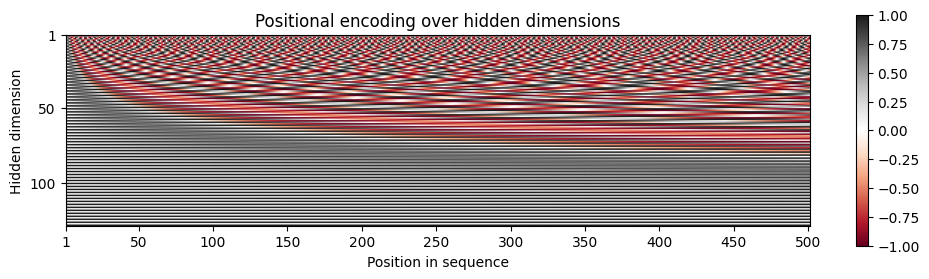

In [31]:
pe = PositionalEncoding_layer.PositionalMat().squeeze().T

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*50 for i in range(1,1+pe.shape[1]//50)])
ax.set_yticks([1]+[i*50 for i in range(1,1+pe.shape[0]//50)])
plt.show()

> Several positional encoding values are shown below

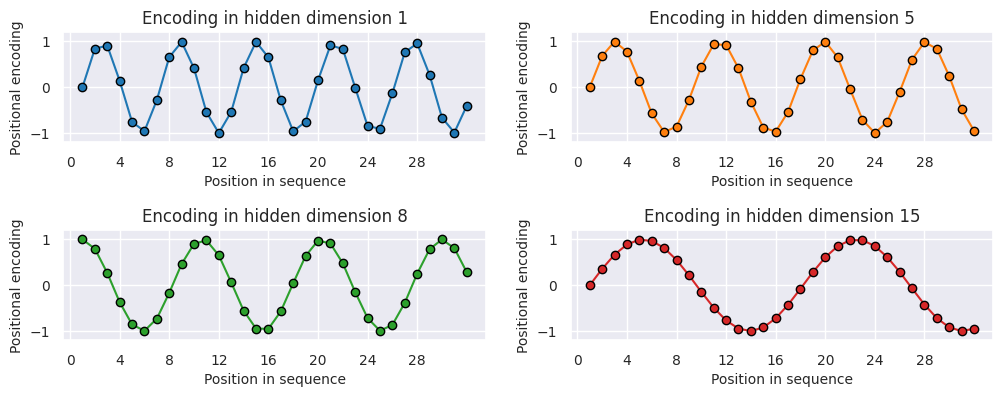

In [32]:
import seaborn as sns
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
a_list = [0, 4, 7, 14]
upto = 32
ax = [a for a_list in ax for a in a_list]
for i, j in enumerate(a_list):
    ax[i].plot(np.arange(1,upto+1), pe[j,:upto], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {j+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks((np.arange(1,(upto+1),4))-1)
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

## Attention mechanism

<center width="100%"><img src="data/transformer_architecture.svg" width="400px"></center>

From the embedded input of shape `(batch_size, seq_len, embedding_dim)`, we compute three components
- Query: $Q = XW^Q$, where $W^Q \in \mathcal{R}^{d_k \, \times \, EmbedDim}$
- Key: $K = XW^K$, where $W^Q \in \mathcal{R}^{d_k \, \times \, EmbedDim}$
- Value: $V = XW^V$, where $W^Q \in \mathcal{R}^{d_v \, \times \, EmbedDim}$

Note: $W^Q$, $W^K$, and $W^V$ are learnable weights. For simplicity, we use $d_k = d_v = EmbedDim$.

<center width="100%"><img src="data/single_QKV.png" width="800px"></center>


In [33]:
class QKV_projection_layer_basic(nnx.Module):
    def __init__(self, config: config_dict, rngs=nnx.Rngs):
        self.config = config
        self.linear_q = nnx.Linear(self.config.embed_dim, self.config.embed_dim, rngs=rngs)
        self.linear_k = nnx.Linear(self.config.embed_dim, self.config.embed_dim, rngs=rngs)
        self.linear_v = nnx.Linear(self.config.embed_dim, self.config.embed_dim, rngs=rngs)
        
    def __call__(self, x: jax.Array) -> jax.Array:
        q = self.linear_q(x)
        k = self.linear_k(x)
        v = self.linear_v(x)
        return q, k, v

# Simpler version
class QKV_projection_layer(nnx.Module):
    def __init__(self, config: config_dict, rngs=nnx.Rngs):
        self.config = config
        self.qkv_proj = nnx.Linear(self.config.embed_dim, 3 * self.config.embed_dim, rngs = rngs)
        
    def __call__(self, x: jax.Array) -> jax.Array:
        qkv = self.qkv_proj(x)
        q, k, v = jnp.split(qkv, 3, axis=-1)
        return q, k, v
    
qkv_projection_layer = QKV_projection_layer(config, rngs=nnx.Rngs(main_rng))
Q, K, V = qkv_projection_layer(PositionalEncoding_layer(input_embedding_layer(batch_input_one_hot_data)))
print(f'Q shape: {Q.shape}, K shape: {K.shape}, V shape: {V.shape}')

Q shape: (99, 14, 128), K shape: (99, 14, 128), V shape: (99, 14, 128)



### Single-head attention

The attention value from element $i$ to $j$ is based on its similarity of the query $Q_i$ and key $K_j$, using the dot product as the similarity metric. In math, we calculate the dot product attention as follows:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $T\times T$, T is the `config.seq_len`. Each row represents the attention logits for a specific element $i$ to all other elements in the sequence. On these, we apply a softmax and multiply with the value vector to obtain a weighted mean (the weights being determined by the attention). Another perspective on this attention mechanism offers the computation graph which is visualized below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="data/scaled_dot_product_attn.svg" width="210px"></center>

The weights of the average are calculated by a softmax over all score function outputs. Hence, we assign those value vectors a higher weight whose corresponding key is most similar to the query. If we try to describe it with pseudo-math, we can write: 

$$
\alpha_i = \frac{\exp\left(f_{attn}\left(\text{key}_i, \text{query}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{key}_j, \text{query}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{value}_i
$$

Visually, we can show the attention over a sequence of words as follows:

<center width="100%" style="padding:25px"><img src="data/attention_example.svg" width="750px"></center>

The block `Mask (opt.)` in the diagram above represents the optional masking of specific entries in the attention matrix. This is for instance used if we stack multiple sequences with different lengths into a batch. To still benefit from parallelization in PyTorch, we pad the sentences to the same length and mask out the padding tokens during the calculation of the attention values. This is usually done by setting the respective attention logits to a very low value. However, we will not use masking in this notebook, if you would like to include it, you can refer any benchmark code on Jax or PyTorch or TensorFlow.

In [34]:
class SingleAttentionBlock(nnx.Module):
    def __init__(self):
        pass
    
    def __call__(self, Q, K, V, mask=None):
        embded_dim = Q.shape[-1]
        attn_logits = jnp.matmul(Q, jnp.swapaxes(K, -2, -1))
        attn_logits = attn_logits / math.sqrt(embded_dim)
        if mask is not None:
            pass
        attention = nnx.softmax(attn_logits, axis=-1)
        values = jnp.matmul(attention, V)
        return values, attention
    
single_attention_block = SingleAttentionBlock()

vals, attn = single_attention_block(Q, K, V)
print(f'vals shape: {vals.shape}, attn shape: {attn.shape}')


vals shape: (99, 14, 128), attn shape: (99, 14, 14)


### Multi-head attention

The scaled dot product attention allows a network to attend over a sequence. However, often there are multiple different aspects a sequence element wants to attend to, and a single weighted average is not a good option for it. This is why we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features. Specifically, given a query, key, and value matrix, we transform those into $h$ sub-queries, sub-keys, and sub-values, which we pass through the scaled dot product attention independently. Afterward, we concatenate the heads and combine them with a final weight matrix. Mathematically, we can express this operation as:

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(XW_i^Q,XW_i^K, XW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer with the learnable parameters 

$W_{1...h}^{Q}\in\mathbb{R}^{S_z \times EmbedDim}$, 

$W_{1...h}^{K}\in\mathbb{R}^{S_z \times EmbedDim}$, 

$W_{1...h}^{V}\in\mathbb{R}^{S_z \times EmbedDim}$, 

and $W^{O}\in\mathbb{R}^{h \cdot S_z\times EmbedDim}$ ($D$ being the input dimensionality).

NOTE: The number of heads $h$ is chosen such that $h . S_z = EmbedDim$

Expressed in a computational graph, we can visualize it as below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="data/multi_head.png" width="800px"></center>



In [35]:

config.num_heads = 2

class MultiHeadAttention(nnx.Module):
    def __init__(self, config: config_dict, rngs=nnx.Rngs):
        self.config = config
        self.head_dim = self.config.embed_dim // self.config.num_heads
        
        self.qkv_proj = nnx.Linear(self.config.embed_dim, 3 * self.config.embed_dim, rngs = rngs)
        self.out_proj = nnx.Linear(self.config.embed_dim, self.config.embed_dim, rngs = rngs)
    
        self.attn_block = SingleAttentionBlock()
    
    def __call__(self, x: jax.Array) -> jax.Array:
        batch_size = x.shape[0]
        seq_len = x.shape[1]
        
        # Seperate Q, K, V from linear output
        qkv = self.qkv_proj(x)
        qkv = jnp.reshape(qkv, (batch_size, seq_len, self.config.num_heads, -1))
        qkv = jnp.transpose(qkv, (0, 2, 1, 3)) # [Batch, Head, SeqLen, HeadDim]
        
        q, k, v = jnp.split(qkv, 3, axis=-1)
        
        values, attentions = self.attn_block(q, k, v)
        values = jnp.transpose(values, (0, 2, 1, 3)) # [BatchSize, SeqLen, NumHeads, HeadDim] 
        values = jnp.reshape(values, (batch_size, seq_len, self.config.embed_dim))
        out = self.out_proj(values)
        return out, attentions
    
multi_head_attention = MultiHeadAttention(config, rngs=nnx.Rngs(main_rng))
input_to_multi_head_attention = PositionalEncoding_layer(input_embedding_layer(batch_input_one_hot_data))
output_multi_head_attention, attention_multi_head_attention = multi_head_attention(input_to_multi_head_attention)
print(f'output shape: {output_multi_head_attention.shape}')
print(f'attention shape: {attention_multi_head_attention.shape}')

output shape: (99, 14, 128)
attention shape: (99, 2, 14, 14)


## Fully connected feed-forward network

<center width="100%"><img src="data/transformer_architecture.svg" width="400px"></center>

Additionally to the Multi-Head Attention, a small fully connected feed-forward network is added to the model, which is applied to each position separately and identically. Specifically, the model uses a Linear$\to$ReLU$\to$Linear MLP. The full transformation including the residual connection can be expressed as:  

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2
\end{split}
$$


In [36]:
config.feedforward_dim = 256

## Collect components and build a Encoder block

<center width="100%"><img src="data/transformer_architecture.svg" width="400px"></center>


In [37]:

class EncoderBlock(nnx.Module):
    def __init__(self, config: config_dict, rngs=nnx.Rngs):
        self.config = config
        # Multi Head Attention
        self.multi_head_attention = MultiHeadAttention(self.config, rngs=rngs)
        self.layer_norm1 = nnx.LayerNorm(self.config.embed_dim, rngs=rngs)

        # Two-layer MLP
        self.feed_forward = [
            nnx.Linear(self.config.embed_dim, self.config.feedforward_dim, rngs=rngs),
            nnx.relu,
            nnx.Linear(self.config.feedforward_dim, self.config.embed_dim, rngs=rngs),
        ]
        self.layer_norm2 = nnx.LayerNorm(self.config.embed_dim, rngs=rngs)
    
    def __call__(self, x: jax.Array) -> jax.Array:
        attn_out, _ = self.multi_head_attention(x)
        x = self.layer_norm1(x + attn_out)
        
        # MLP part
        linear_out = x
        for layer in self.feed_forward:
            linear_out = layer(linear_out)
            
        x = self.layer_norm2(x + linear_out)
        return x
    
transformer_encoder_block = EncoderBlock(config, rngs=nnx.Rngs(main_rng))
output_encoder_block = transformer_encoder_block(output_of_embedding_layer)

print(f'output of encoder block shape: {output_encoder_block.shape}')

output of encoder block shape: (99, 14, 128)


## A sequence of Encoder blocks

<center width="100%"><img src="data/transformer_architecture.svg" width="400px"></center>

> We add a function to return attention matrix for tracking

In [38]:

config.num_blocks = 2

class TransformerEncoder(nnx.Module):
    def __init__(self, config: config_dict, rngs=nnx.Rngs):
        self.config = config
        
        self.encoder_blocks = [EncoderBlock(self.config, rngs=rngs) for _ in range(self.config.num_blocks)]
        
    def __call__(self, x):
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
        return x
    
    def get_attention_matrix(self, x):
        # A function to return the attention maps within the model for a single application
        # Used for visualization purpose later
        attention_matrices = []
        for encoder_block in self.encoder_blocks:
            x, attn = encoder_block.multi_head_attention(x)
            attention_matrices.append(attn)
            x = encoder_block(x)
        
        return attention_matrices
            
transformer_encoder = TransformerEncoder(config, rngs=nnx.Rngs(main_rng))
output_sequence_of_encoders = transformer_encoder(output_of_embedding_layer)
print(f'output_sequence_of_encoders shape: {output_sequence_of_encoders.shape}')

attn_lists = transformer_encoder.get_attention_matrix(output_of_embedding_layer)
print(f'length of attention list: {len(attn_lists)}')

output_sequence_of_encoders shape: (99, 14, 128)
length of attention list: 2


## A complete Transformer model

<center width="100%"><img src="data/transformer_architecture.svg" width="400px"></center>

> We also need to add an extra layer to map from encoder block output space `config.embed_dim` back to the original feature space `config.num_classes`.

In [39]:

class TransformerPredictor(nnx.Module):
    def __init__(self, config: config_dict, rngs=nnx.Rngs):
        self.config = config
        self.embedding_layer = Imbedding_input_layer(self.config, rngs=rngs)
        self.transformer_encoder = TransformerEncoder(self.config, rngs=rngs)
        self.PositionalEncoding_layer = PositionalEncoding(self.config)
        
        # output classifier per sequence element
        self.output_layer = [
            nnx.Linear(self.config.embed_dim, self.config.embed_dim, rngs=rngs),
            nnx.LayerNorm(self.config.embed_dim, rngs=rngs),
            nnx.relu,
            nnx.Linear(self.config.embed_dim, self.config.num_classes, rngs=rngs),
        ]
    def __call__(self, x):
        x = self.embedding_layer(x)
        x = self.PositionalEncoding_layer(x)
        x = self.transformer_encoder(x)
        for layers in self.output_layer:
            x = layers(x)
        return x
    
    def get_attn_mats(self, x):
        x = self.embedding_layer(x)
        x = self.PositionalEncoding_layer(x)
        attn_mats = self.transformer_encoder.get_attention_matrix(x)
        
        return attn_mats
    
transformer_predictor = TransformerPredictor(config, rngs=nnx.Rngs(main_rng))
output_pred = transformer_predictor(batch_input_one_hot_data)

print(f'output_pred by Transformer shape: {output_pred.shape}\n')

attn_mats = transformer_predictor.get_attn_mats(batch_input_one_hot_data[0:1,...])
print(f'attns shape: {jnp.asarray(attn_mats).shape}')
print(f'attention has {len(attn_mats)} elements = {config.num_blocks} blocks')
print('Each of blocks has shape of batch x numheads x seq_len x seq_len')


output_pred by Transformer shape: (99, 14, 10)

attns shape: (2, 1, 2, 14, 14)
attention has 2 elements = 2 blocks
Each of blocks has shape of batch x numheads x seq_len x seq_len


# Generate training/validation/inference data

In [40]:
config.num_train_data = 50000
config.num_val_data = 1000
config.num_test_data = 100

# training data
train_input_data = jax.random.randint(main_rng, (config.num_train_data, config.seq_len), 0, config.num_classes)
train_labels = train_input_data[:,::-1]

# Validation data
val_input_data = jax.random.randint(main_rng, (config.num_val_data, config.seq_len), 0, config.num_classes)
val_labels = val_input_data[:,::-1]

# Inference/Test data
test_input_data = jax.random.randint(main_rng, (config.num_test_data, config.seq_len), 0, config.num_classes)
test_labels = test_input_data[:,::-1]

print(test_labels.shape)

(100, 14)


# Train module/APIs

In [ ]:
class TrainState(train_state.TrainState):
    graphdef: nnx.GraphDef
    other_variables: nnx.State

class Trainer_Module:
    def __init__(self, config: config_dict):
        """Initialize the Trainer with attributes
        0. model - Transformer
        1. loss function
        2. train and evaluation functions
        3. optimizer
        4. training epoch
        5. upload wandb
        6. save and load best eval model

        Args:
            config (config_dict): configuration settings
        """
        super().__init__()
        self.config = config
        
        self.model = TransformerPredictor(self.config, rngs=nnx.Rngs(config.random_seed))
        
        # Initialize model
        self.init_model()
        
        # Created jitted function for training and eval functions
        self.create_functions()
        self.create_train_eval_funcs()
        
        # wandb logging
        self.file_name_for_run = f'{self.config.num_blocks}blocks_{self.config.num_heads}heads'
        self.tracing_with_wandb()
        
        # save and load model functions
        self.save_and_load_models()
        self.model_path = os.path.join(os.getcwd(), 'models', self.file_name_for_run)
        
    def init_model(self):
        """create a TrainState including
        1. trainable model parameters
        2. optimizer
        3. other variables of models
        """
        
        self.graphdef, params, self.other_variables = nnx.split(self.model, nnx.Param, ...)
        
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.config.learning_rate,
            warmup_steps=self.config.warmup_steps,
            decay_steps=self.config.max_iters,
            end_value=0.0
        )
        optax_optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),
            optax.adam(lr_schedule)
        )
        
        self.state = TrainState.create(
            apply_fn=self.graphdef.apply,
            graphdef=self.graphdef,
            params=params,
            other_variables=self.other_variables,
            tx=optax_optimizer,
            )
    
    def get_loss_function(self):
        """create a loss function for a batch of data samples

        Returns:
            callable function: a loss function
        """
        def calculate_loss(params, batch):
            """loss function for a batch of data samples with current model parameters

            Args:
                params (Jax.Array): neural network parameters
                batch (Jax.Array): batch of data samples

            Returns:
                loss (float scalar): loss value for the batch
            """
            
            model = nnx.merge(self.state.graphdef, params, self.other_variables)
            inp_data, labels = batch
            inp_data = jax.nn.one_hot(inp_data, self.config.num_classes)
            logits = model(inp_data)
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            return loss
        
        return calculate_loss
    
    def create_functions(self):
        """
        Create jitted functions
        1. train step
        2. eval step
        3. Generating a data batch
        """
        
        calculate_loss = self.get_loss_function()
        
        @jax.jit
        def train_step(state, batch):
            loss, grads = jax.value_and_grad(calculate_loss)(state.params, batch)
            state = state.apply_gradients(grads=grads)
            return loss, state
        
        @jax.jit
        def eval_step(state, batch):
            loss = calculate_loss(state.params, batch)
            return loss
        
        self.train_step = train_step
        self.eval_step = eval_step
        
        
        @jax.jit
        def data_batchize(batch_idx, total_data):
            out_data = jax.lax.dynamic_slice(
                    total_data,
                    (batch_idx * self.config.batch_size,) + (0,) * (total_data.ndim - 1),
                    (self.config.batch_size,) + total_data.shape[1:]  # Create tuple by concatenating
                )
            return out_data
        
        self.data_batchize = data_batchize
        
    def create_train_eval_funcs(self):
        
        def train_epoch(state, train_inp_data, train_labels):
            # Train state for a single epoch
            train_loss = 0.0
            for batch_idx in range(train_inp_data.shape[0] // self.config.batch_size):
                
                batch_inp_data = self.data_batchize(batch_idx, train_inp_data)
                batch_labels = self.data_batchize(batch_idx, train_labels)
                
                loss, state = self.train_step(state, (batch_inp_data, batch_labels))
                train_loss += loss
                
            return train_loss, state
        
        def eval_model(state, val_inp_data, val_labels):
            # Evaluate state on validation set
            val_loss = 0.0
            for batch_idx in range(val_inp_data.shape[0] // self.config.batch_size):
                batch_inp_data = self.data_batchize(batch_idx, val_inp_data) 
                batch_labels = self.data_batchize(batch_idx, val_labels)
                
                loss = self.eval_step(state, (batch_inp_data, batch_labels))
                val_loss += loss
                
            return val_loss
        
        self.train_epoch = train_epoch
        self.eval_model = eval_model
        
    def train_model(self, train_inp_data, train_labels, val_inp_data, val_labels):
        """training the model

        Args:
            train_inp_data (Jax.Array)
            train_labels (Jax.Array)
            val_inp_data (Jax.Array)
            val_labels (Jax.Array)
        """
        best_val_loss = 100
        
        for epoch_idx in range(1, self.config.num_epochs+1): # loop through all epochs
            self.model.train()
            start = time.time()
            train_loss, self.state = self.train_epoch(self.state, train_inp_data, train_labels)
            time_train_per_epoch = time.time() - start
            
            if epoch_idx % self.config.print_eval_every == 0:
                self.model.eval()
                val_loss = self.eval_model(self.state, val_inp_data, val_labels)
                print(f"Epoch {epoch_idx}, Time {time_train_per_epoch:.2f} Train Loss {train_loss:.3f}, Val Loss: {val_loss:.3f}")
                
                if config.wandb_upload is not False:
                    self._upload_wandb(train_loss, val_loss, epoch_idx)
                
                if val_loss < best_val_loss:
                    # Merge the model for validation
                    best_val_loss = val_loss
                    self.model = nnx.merge(self.state.graphdef, self.state.params, self.state.other_variables)
                    self.saved_model(self.model)
                    print('='*10 + f'Best model saved at epoch {epoch_idx}')
                    
        self.model = nnx.merge(self.state.graphdef, self.state.params, self.state.other_variables)
    
    def save_and_load_models(self):
        checkpointer = ocp.StandardCheckpointer()
        
        def saved_model(model):
            # Check if directory exists 
            # # Remove directory and all its contents
            if os.path.exists(self.model_path):
                shutil.rmtree(self.model_path) 
                
            _, state = nnx.split(model)
            checkpointer.save(self.model_path, state)
        
        def load_model_for_inference():
            """Load model from file."""
            abstract_model = nnx.eval_shape(lambda: self.model)
            graphdef, abstract_state = nnx.split(abstract_model)
            state_restored = checkpointer.restore(self.model_path, abstract_state)
            self.model = nnx.merge(graphdef, state_restored)
            
        self.saved_model = saved_model
        self.load_model_for_inference = load_model_for_inference
    
    def tracing_with_wandb(self):
        if config.wandb_upload is not False: # for good practice, use this for clear condition
            wandb.init(project="Tutorial_Transformer", entity="hainguyenpho", name=self.file_name_for_run)
            wandb.config.problem = 'Transport_equation'
        
        def upload_loss_values_to_wandb(train_loss, val_loss, epoch_idx):
            wandb.log({"train_loss": train_loss, "val_loss": val_loss, "epoch": epoch_idx})
            
        self._upload_wandb = upload_loss_values_to_wandb

In [65]:
config.batch_size = 100
config.num_epochs = 30

# Optimizer
config.max_iters = config.num_epochs * (config.num_train_data // config.batch_size)
config.learning_rate = 1e-3
config.warmup_steps = 5
config.print_eval_every = 3

config.num_blocks = 1
config.num_heads = 1

config.wandb_upload = True

train_task = Trainer_Module(config)
train_task.train_model(train_input_data, train_labels, val_input_data, val_labels)

Epoch 3, Time 0.72 Train Loss 0.039, Val Loss: 0.001
==========Best model saved at epoch 3
Epoch 6, Time 0.72 Train Loss 0.007, Val Loss: 0.000
==========Best model saved at epoch 6
Epoch 9, Time 0.72 Train Loss 0.003, Val Loss: 0.000
==========Best model saved at epoch 9
Epoch 12, Time 0.72 Train Loss 0.001, Val Loss: 0.000
==========Best model saved at epoch 12
Epoch 15, Time 0.72 Train Loss 0.000, Val Loss: 0.000
==========Best model saved at epoch 15
Epoch 18, Time 0.72 Train Loss 0.000, Val Loss: 0.000
==========Best model saved at epoch 18
Epoch 21, Time 0.72 Train Loss 0.000, Val Loss: 0.000
==========Best model saved at epoch 21
Epoch 24, Time 0.72 Train Loss 0.000, Val Loss: 0.000
==========Best model saved at epoch 24
Epoch 27, Time 0.72 Train Loss 0.000, Val Loss: 0.000
==========Best model saved at epoch 27
Epoch 30, Time 0.72 Train Loss 0.000, Val Loss: 0.000
==========Best model saved at epoch 30


## Load the saved model

In [55]:
config.num_blocks = 1
config.num_heads = 1

train_task = Trainer_Module(config)
train_task.load_model_for_inference()


/usr/local/lib/python3.11/dist-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


## Visualize the attention matrix

(1, 1, 14, 14)


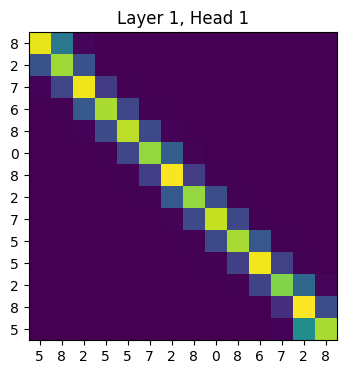

In [56]:
a_sample_test_data = test_input_data[0:1,:]
attention_maps = train_task.model.get_attn_mats(jax.nn.one_hot(a_sample_test_data, config.num_classes))
print(attention_maps[0].shape)

def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = jax.device_get(input_data[idx])
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [jax.device_get(m[idx]) for m in attn_maps]
    
    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()
    
plot_attention_maps(a_sample_test_data, attention_maps, idx=0)


In [ ]:
jax.nn.one_hot(a_sample_test_data, config.num_classes).shape

(1, 14, 10)